In [64]:
import pandas as pd
import alpha_beta as ab
import matplotlib.pyplot as plt
import seaborn as sns

#df1_name =  "df1_20000_50.csv" #"df1.csv"
#df2_name = "df2_20000_50.csv" # "df2.csv" #



store = True
store_plot = True

df1_name =  "/workspaces/python-2/data_obesity/obesity1_750_7.csv" #"income_df1_1000_10.csv" #"df1.csv"
df2_name =  "/workspaces/python-2/data_obesity/obesity2_750_7.csv" #"income_df2_1000_10.csv" # "df2.csv" 

#load dfs
df1 = pd.read_csv(df1_name)
df2 = pd.read_csv(df2_name)
#original to store it as reference
original_df1 = pd.read_csv(df1_name)
original_df2 = pd.read_csv(df2_name)
#intialize clusters
df1["cluster"] = 0
df2["cluster"] = 0 
original_df1["cluster"] = 0
original_df2["cluster"] = 0 
 
#------------------------------------PARAMETERS------------------------
MinClusterSize=5# MAX 7

method = "ord_sample" #"choice"->at least 1/"sample"-> exactly 1; ord_sample -> sample preserving order
#If the clusters must be generalized
generalize = True

sensitive_column = "NObeyesdad"
quasiidentifiers = ["Gender","Age","Height","Weight","NCP","CH2O","FAF"]  
attributes = ["Gender","Age","Height","Weight","NCP","CH2O","FAF","NObeyesdad"]
#-----------------------------------------------------------------------
#Add risk columns as default is less than 1/Minclustersize
df1["risk"] = 1/MinClusterSize
df2["risk"] = 1/MinClusterSize
original_df1["risk"] = 1/MinClusterSize
original_df2["risk"] = 1/MinClusterSize

#ab.check_eligibility(df1["occupation"].value_counts().to_list(),5)
#df2


In [65]:

#Create cluster for each publication
ab.compute_clusters(df=df1,sensitive_column=sensitive_column,MinClusterSize=MinClusterSize)
ab.compute_clusters(df=df2,sensitive_column=sensitive_column,MinClusterSize=MinClusterSize)

#Optimize clusters
ab.optimize_clusters(df1,sensitive_column,quasiidentifiers,generalize=generalize)
#df1.to_csv(df1_name[:-4]+"_"+str(MinClusterSize)+"_"+"cluster.csv",index=False)


,Gender,Age,Height,Weight,NCP,CH2O,FAF,NObeyesdad,identifier,cluster,risk
0,0.8,0.235767,0.471318,0.386322,0.666667,0.522870,0.011006,1,366,1,0.2
1,1.0,0.139702,0.704236,0.524328,0.628476,0.776194,0.393285,5,860,2,0.2
2,0.2,0.187727,0.252587,0.303238,0.588965,0.020886,0.076577,1,272,3,0.2
3,0.8,0.220442,0.526152,0.423865,0.666667,0.452091,0.089586,4,1862,4,0.2
4,0.8,0.178276,0.597670,0.480154,0.653828,0.496419,0.407898,4,1873,5,0.2
...,...,...,...,...,...,...,...,...,...,...,...
745,1.0,0.101827,0.603386,0.300853,0.655826,0.503333,0.397793,6,1194,142,0.2
746,1.0,0.192588,0.580865,0.328304,0.618422,0.407913,0.624222,0,717,149,0.2
747,1.0,0.192588,0.580865,0.328304,0.618422,0.407913,0.624222,2,1355,149,0.2
748,0.8,0.156174,0.496875,0.260269,0.732350,0.665408,0.664061,6,1125,144,0.2


In [66]:
#copy clusters generated prior to casino privacy
cluster_df1 = df1.copy()
cluster_df2 = df2.copy()


#compute shared tuples
merged_df = pd.merge(df1, df2, on='identifier', how='inner')
merged_df = merged_df[["identifier","cluster_x","cluster_y"]]
shared_identifiers = merged_df["identifier"].to_list()

#Make permutation version
generalized_df1 = df1.copy()
generalized_df2 = df2.copy()


# and store
if store:

    generalized_df1.to_csv("/workspaces/python-2/cache_operations/obesity1_"+str(MinClusterSize)+"_"+"generalized_"+str(generalize)+".csv",index=False)
    generalized_df2.to_csv("/workspaces/python-2/cache_operations/obesity2_"+str(MinClusterSize)+"_"+"generalized_"+str(generalize)+".csv",index=False)
    all_generalized = pd.concat([generalized_df1,generalized_df2])
    all_generalized.to_csv("/workspaces/python-2/cache_operations/obesity_all_"+str(MinClusterSize)+"_"+"generalized_"+str(generalize)+".csv",index=False)

#Enforce casino-privacy
ab.randomize_clusters(df=df2,sensitive_column=sensitive_column,method =method)
ab.randomize_clusters(df=df1,sensitive_column=sensitive_column,method =method)

if store:
    df1.to_csv("/workspaces/python-2/cache_operations/obesity1_"+str(MinClusterSize)+"_"+method+"_"+"cp_"+"generalized_"+str(generalize)+".csv",index=False)
    df2.to_csv("/workspaces/python-2/cache_operations/obesity2_"+str(MinClusterSize)+"_"+method+"_"+"cp_"+"generalized_"+str(generalize)+".csv",index=False)
    all_generalized = pd.concat([df1,df2])
    all_generalized.to_csv("/workspaces/python-2/cache_operations/obesity_all_"+str(MinClusterSize)+"_"+method+"_"+"cp_"+"generalized_"+str(generalize)+".csv",index=False)




In [67]:
#Compute intersection attacks and check intersection is pairwise

#Check intersection is pairwise df1, df2
#Shared identifiers
merged_df = pd.merge(df1, df2, on='identifier', how='inner')

merged_df = merged_df[["identifier","cluster_x","cluster_y"]]
shared_identifiers = merged_df["identifier"].to_list()

tmpx= max(merged_df["cluster_x"].value_counts().to_list())

tmpy= max(merged_df["cluster_y"].value_counts().to_list())

if max(tmpx,tmpy)==1:
    print("All ok")
else:
    print("Warning:Risk of non-paiwise association")
    print(tmpx,tmpy)
all_ok = max(tmpx,tmpy)==1

#merged_df


All ok


In [68]:
#Compute risks of casino private clusters
for user in merged_df["identifier"].value_counts().index.to_list(): #for each pair of clusters with a shared user
    #user = 39652 #test
    #cluster of user
    #print(user)
    [cluster_1] = merged_df.loc[merged_df["identifier"]==user,"cluster_x"].to_list()
    [cluster_2] = merged_df.loc[merged_df["identifier"]==user,"cluster_y"].to_list()
    #compute signature of those clusters
    signature_1 = df1.loc[df1["cluster"]==cluster_1,sensitive_column].to_list()
    signature_2 = df2.loc[df2["cluster"]==cluster_2,sensitive_column].to_list()
    #compute v1,k1,v2,k2,delta,(j=1)
    delta = len(set(signature_1) & set(signature_2) )  # shared values
    v1 = len(signature_1)-len(set(signature_1))        # repeated values of cluster_1
    k1 = len(signature_1)-delta-v1                     # unique values of cluster_1
    v2 = len(signature_2)-len(set(signature_2))        # repeated values of cluster_1
    k2 = len(signature_2)-delta-v2                     # unique values of cluster_1
    U = delta+k1*v2+k2*v1+v1*v2
    #we compute the risk depending on the case for each tuple in cluster
    #users in cluster of df1
    cluster_1_identifier = df1.loc[(df1["cluster"]==cluster_1) & (df1["identifier"] != user),"identifier"].to_list()

    for identifier in cluster_1_identifier:
        #true sd of user with identifier
        
        [sd_user] = original_df1.loc[original_df1["identifier"]==identifier,sensitive_column].to_list()
        if sd_user in signature_1 and sd_user in signature_2: #shared between clusters 
            #only nontight cas
            df1.loc[df1["identifier"]==identifier,"risk"] =   (U-1+v1)/(U*(len(signature_1)-1))
            if MinClusterSize==2:
                df1.loc[df1["identifier"]==identifier,"risk"] =   1/2
        else:
            df1.loc[df1["identifier"]==identifier,"risk"] = (U-v2)/(U*(len(signature_1)-1))
    #compute the risk of the shared user
    [sd_user] = original_df1.loc[original_df1["identifier"]==user,sensitive_column].to_list()
    if sd_user in signature_1 and sd_user in signature_2:
        df1.loc[df1["identifier"]==user,"risk"] = 1/U
    elif sd_user in signature_1:
        df1.loc[df1["identifier"]==user,"risk"] = v2/U
    elif sd_user in signature_2:
        df1.loc[df1["identifier"]==user,"risk"] = v1/U
    else:
        df1.loc[df1["identifier"]==user,"risk"] = 0 #if info not in any of the clusters

#df1.loc[df1["cluster"]==cluster_1]
        
    


In [69]:
#Compute risks of NON casino private clusters
for user in merged_df["identifier"].value_counts().index.to_list(): #for each pair of clusters with a shared user
    #user = 39652 #test
    #cluster of user
    [cluster_1] = merged_df.loc[merged_df["identifier"]==user,"cluster_x"].to_list()
    [cluster_2] = merged_df.loc[merged_df["identifier"]==user,"cluster_y"].to_list()
    #compute signature of those clusters
    signature_1 = cluster_df1.loc[cluster_df1["cluster"]==cluster_1,sensitive_column].to_list()
    signature_2 = cluster_df2.loc[cluster_df2["cluster"]==cluster_2,sensitive_column].to_list()
    #compute v1,k1,v2,k2,delta,(j=1)
    delta = len(set(signature_1) & set(signature_2) )  # shared values
    #v1 = len(signature_1)-len(set(signature_1))        # repeated values of cluster_1
    k1 = len(signature_1)-delta                   # unique values of cluster_1
    #v2 = len(signature_2)-len(set(signature_2))        # repeated values of cluster_1
    k2 = len(signature_2)-delta                     # unique values of cluster_1
    
    #we compute the risk depending on the case for each tuple in cluster
    #users in cluster of df1 
    cluster_1_identifier = cluster_df1.loc[(cluster_df1["cluster"]==cluster_1) & (cluster_df1["identifier"] != user),"identifier"].to_list()
    
    #compute the risk of the NOT shared user
    for identifier in cluster_1_identifier:
        #true sd of user with identifier
        [sd_user] = original_df1.loc[original_df1["identifier"]==identifier,sensitive_column].to_list()
        if sd_user in signature_1 and sd_user in signature_2: #shared sd between clusters
            cluster_df1.loc[cluster_df1["identifier"]==identifier,"risk"] =   (delta-1)/(delta*(k1+delta-1))
        else:
            cluster_df1.loc[cluster_df1["identifier"]==identifier,"risk"] = (1)/(k1+delta-1)
    #compute the risk of the shared user
    [sd_user] = original_df1.loc[original_df1["identifier"]==user,sensitive_column].to_list()
    if sd_user in signature_1 and sd_user in signature_2:
        cluster_df1.loc[cluster_df1["identifier"]==user,"risk"] = 1/delta
    #elif sd_user in signature_1:
        #cluster_df1.loc[cluster_df1["identifier"]==user,"risk"] = v2/U
    #elif sd_user in signature_2:
        #cluster_df1.loc[cluster_df1["identifier"]==user,"risk"] = v1/U
    else:
        print("Error: no consistent sd")
        #cluster_df1.loc[cluster_df1["identifier"]==user,"risk"] = 0 #if info not in any of the clusters

#df1.loc[df1["cluster"]==cluster_1]
    


In [70]:
# #Plot the risk for each df only of tuples in interesting clusters

merged_risk = pd.merge(df1, df2, on='identifier', how='inner')

interesting_clusters_df1 = merged_risk["cluster_x"].to_list()
interesting_clusters_df1 = list(set(interesting_clusters_df1))

int_df1 = df1.loc[df1["cluster"].isin(interesting_clusters_df1)].reset_index(drop=True)
int_cl_df1 = cluster_df1.loc[cluster_df1["cluster"].isin(interesting_clusters_df1)].reset_index(drop=True)

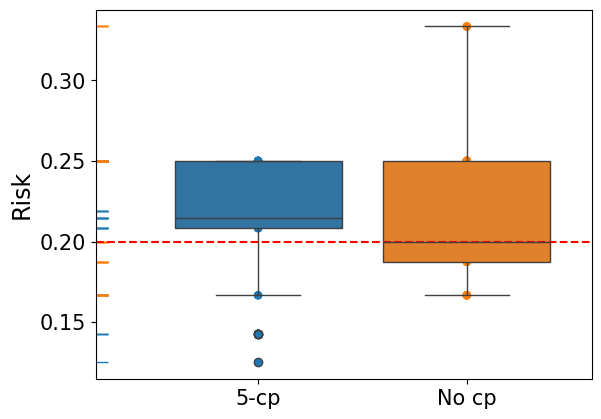

max risk cp:  0.25 , nº: 13
max risk cl:  0.3333333333333333 , nº: 4
True


In [71]:
# Combine the two columns into a single DataFrame with a 'key' column
combined_df = pd.concat([int_df1.assign(key=str(MinClusterSize)+'-cp'), int_cl_df1.assign(key='No cp')])

custom_palette = ["black","black"]
ax= sns.boxplot(data=combined_df,x="key", y='risk',hue="key") #,flier_kws=dict(facecolor=".7", linewidth=.5,alpha=0))
#ax.set_xlim(0, 1.05)
sns.rugplot(data=combined_df, y='risk',hue="key",legend=False)
sns.scatterplot(data=combined_df, y='risk',x='key',hue="key",linewidth=0,legend=False,marker="o")
plt.axhline(y=1/MinClusterSize, color='red', linestyle='--', label='y=1/'+str(MinClusterSize))
#Font size
ax.tick_params(axis='both', labelsize=15)
ax.set_xlabel("", fontsize=17)  # X-axis label
ax.set_ylabel("", fontsize=17)  # Y-axis label
# Add labels and title
plt.ylabel('Risk')

# Display the plot
intersection_size = len(shared_identifiers)
if store_plot:
    plt.savefig('/workspaces/python-2/PLOTS/boxplot_obesity_'+str(intersection_size)+"_"+str(MinClusterSize)+'_'+str(all_ok)+'.pdf',bbox_inches='tight')
plt.show()
max_risk=(max(int_df1["risk"]))
max_risk_cl=(max(int_cl_df1["risk"]))
print("max risk cp: ",max_risk,", nº:",len(int_df1.loc[int_df1["risk"]>=max_risk]) )
print("max risk cl: ",max_risk_cl,", nº:",len(int_cl_df1.loc[int_cl_df1["risk"]==max_risk_cl]) )
print(all_ok)

In [72]:
#Make query precision comparison?
print(MinClusterSize,all_ok,method)
print(df1_name)

5 True ord_sample
/workspaces/python-2/data_obesity/obesity1_750_7.csv
